In [48]:
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [49]:
train_path = "ift-3395-6390-kaggle-2-competition-fall-2025/train_data.pkl"
test_path  = "ift-3395-6390-kaggle-2-competition-fall-2025/test_data.pkl"


In [50]:
with open(train_path, "rb") as f:
    train_data = pickle.load(f)
with open(test_path, "rb") as f:
    test_data = pickle.load(f)

X = train_data["images"]
y = train_data["labels"].reshape(-1)
X_test = test_data["images"]


In [51]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [52]:
classes_to_augment = [1, 2, 3, 4]
X_extra, y_extra = [], []
for cls in classes_to_augment:
    idx = np.where(y_tr == cls)[0]
    X_extra.append(X_tr[idx])
    y_extra.append(y_tr[idx])

X_tr = np.concatenate([X_tr] + X_extra)
y_tr = np.concatenate([y_tr] + y_extra)


In [53]:
def extract_features(img_array, n_bins=8, n_circles=3):
    h, w, _ = img_array.shape
    cy, cx = h//2, w//2
    Y, X_coord = np.ogrid[:h, :w]
    radius = np.sqrt((X_coord - cx)**2 + (Y - cy)**2)
    max_radius = radius.max()
    
    features = []
    r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]
    features.extend([r.mean(), g.mean(), b.mean()])
    lum = (0.299*r + 0.587*g + 0.114*b).mean()
    features.append(lum)
    
    for i in range(n_circles):
        mask = (radius >= i*max_radius/n_circles) & (radius < (i+1)*max_radius/n_circles)
        for ch in [r, g, b]:
            vals = ch[mask]
            if len(vals) == 0:
                vals = np.array([0])
            features.extend([vals.mean(), vals.var(), vals.min(), vals.max()])
            hist, _ = np.histogram(vals, bins=n_bins, range=(0,255))
            features.extend(hist / (vals.size if vals.size>0 else 1))
    return np.array(features)

In [54]:
X_tr_feat  = np.array([extract_features(img) for img in X_tr])
X_val_feat = np.array([extract_features(img) for img in X_val])
X_test_feat = np.array([extract_features(img) for img in X_test])


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Modèle de base
clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 20, 100, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='recall_macro',
    n_jobs=-1,
    verbose=2
)

# Entraînement
grid_search.fit(X_tr_feat, y_tr)

# Résultats
print("Best parameters found:", grid_search.best_params_)
print("Best CV recall_macro:", grid_search.best_score_)

# Prédiction sur validation
pred_val = grid_search.predict(X_val_feat)

# Rapport de performance
print(classification_report(y_val, pred_val))



Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

=== Classification report sur la validation ===
              precision    recall  f1-score   support

           0      0.682     0.753     0.716        97
           1      0.267     0.154     0.195        26
           2      0.220     0.220     0.220        41
           3      0.438     0.538     0.483        39
           4      0.200     0.077     0.111        13

    accuracy                          0.500       216
   macro avg      0.361     0.348     0.345       216
weighted avg      0.471     0.500     0.480       216



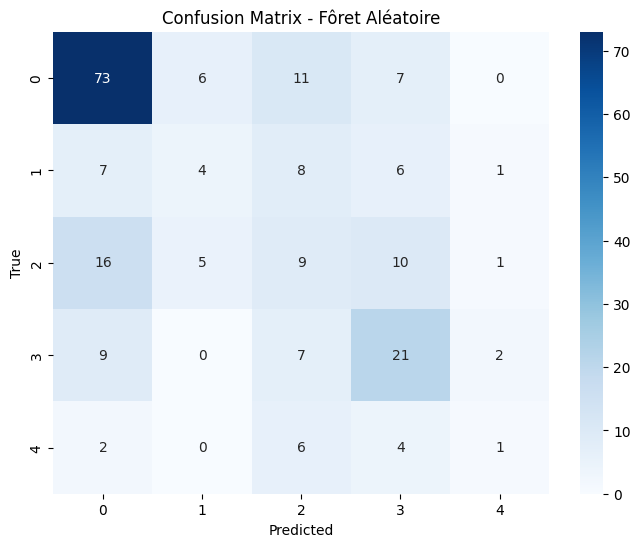

In [72]:

print("=== Classification report sur la validation ===")
print(classification_report(y_val, pred_val, digits=3))



cm = confusion_matrix(y_val, pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fôret Aléatoire')
plt.show()


In [65]:
unique, counts = np.unique(pred_val, return_counts=True)
print("\nNombre de prédictions par classe sur validation :")
for u, c in zip(unique, counts):
    print(f"Classe {u}: {c} images")



Nombre de prédictions par classe sur validation :
Classe 0: 113 images
Classe 1: 12 images
Classe 2: 40 images
Classe 3: 46 images
Classe 4: 5 images


In [66]:
pred_test = grid_search.predict(X_test_feat)


In [67]:
unique_test, counts_test = np.unique(pred_test, return_counts=True)
print("\nNombre de prédictions par classe sur test :")
for u, c in zip(unique_test, counts_test):
    print(f"Classe {u}: {c} images")


Nombre de prédictions par classe sur test :
Classe 0: 214 images
Classe 1: 33 images
Classe 2: 85 images
Classe 3: 58 images
Classe 4: 10 images


In [68]:
results_test = [{"ID": idx, "Label": int(label)} for idx, label in enumerate(pred_test, start=1)]
df_test = pd.DataFrame(results_test)
df_test.to_csv("manual_classification_no_leak_test.csv", index=False)
print("\nCSV test créé avec succès !")



CSV test créé avec succès !
